In [128]:
import MBS_analysis as mbs
import pandas as pd
import pickle
import matplotlib as plt
%matplotlib inline
import numpy as np
from multiprocessing import Pool
import importlib
importlib.reload(mbs)

<module 'MBS_analysis' from '/Users/poyda/Projects/doctor-patient-networks/py/MBS_analysis.py'>

# 1. From raw-data to hierarchical blockmodels
This happens in the four steps below. For details, see the module `MBS_analysis`.

### Raw data $\to$ pandas data frame

Read the first 800,000 rows from the dataset for 2014:

In [ ]:
df = mbs.make_df("../data-raw/MBS_SAMPLE_10PCT_2014.csv", nrows = 800000)

### data frame $\to$ bipartite graph

Create the doctor-patient graph from these rows: 

In [ ]:
g = mbs.patient_doctor_graph(df)

Save the graph for later.

In [ ]:
import pickle
with open("../pickle/graphs/800000.p", 'wb') as fo:
    pickle.dump(g, fo)

### bipartite graph $\to$ hierarchical blockmodel

Load the graph.

In [ ]:
import pickle
with open("../pickle/graphs/800000.p", 'rb') as fo:
    g = pickle.load(fo)

Fit a hierarchical blockmodel `state`, e.g. to Region 1. 

In [ ]:
state = mbs.blockmodel(g, [1])

### hierarchical blockmodel $\to$ extract PPCs

Divide the bottom layer into its connected components:

In [ ]:
state = mbs.extract_PPCs(state)

The `NestedBlockState` object contains the PPCs at the lowest level. Save it:

In [ ]:
with open("../pickle/blockmodels/800000.p", 'wb') as save_to:
    pickle.dump(state, save_to, -1)

# 2. Blockmodels for entire regions

We load one state for each region, pre-calculated on UNSW katana high-performance-computing cluster. (See the scripts in the `pbs` folder.)

In [16]:
with open("../pickle/blockmodels/MBS_SAMPLE_10PCT_2009.csv.p1", 'rb') as fo:
    state1 = pickle.load(fo)
with open("../pickle/blockmodels/MBS_SAMPLE_10PCT_2009.csv.p2", 'rb') as fo:
    state2 = pickle.load(fo)
with open("../pickle/blockmodels/MBS_SAMPLE_10PCT_2009.csv.p3", 'rb') as fo:
    state3 = pickle.load(fo)
with open("../pickle/blockmodels/MBS_SAMPLE_10PCT_2009.csv.p4", 'rb') as fo:
    state4 = pickle.load(fo)
with open("../pickle/blockmodels/MBS_SAMPLE_10PCT_2009.csv.p5", 'rb') as fo:
    state5 = pickle.load(fo)

In [23]:
states = [state1, state2, state3, state4, state5]

Internally, the blocks are indexed by numbers. The indices for the blocks on the lowest level which are PPCs (made up of doctors and not patients) are extracted below. (We only display the first 20 for Region 3.)

In [29]:
mbs.PPCids(states[2])[:20]

PropertyArray([ 0,  1,  3,  4,  5,  7,  8,  9, 10, 12, 14, 15, 16, 18, 19,
               21, 22, 26, 27, 29], dtype=int32)

### Number of PPCs

How many PPCs has our algorithm identified in 2009?

In [379]:
sum(list(map(lambda x: len(mbs.PPCids(x)), states)))

6705

### Statistics on PPC sizes

Calculate the `sizes` of all PPCs and plot the histogram. Below this is done for Region 3. 

In [144]:
def get_PPC_size(k):
    g = mbs.PPCgraph(states[2],k)
    return(sum(g.vp.doctor.a))

with Pool(4) as p:
    sizes = p.map(get_PPC_size, range(len(mbs.PPCids(states[2]))))

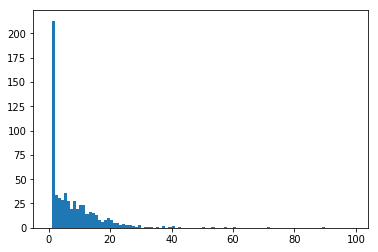

In [145]:
h = plt.pyplot.hist(sizes, bins=range(0,100))

The fraction of PPCs of size 1, 2-6 and 7+ are:

In [146]:
sizes126 = np.array([np.bincount(sizes)[1], sum(np.bincount(sizes)[range(2,7)]), sum(np.bincount(sizes)[7:])])
sizes126 / sum(sizes126)

array([0.34025559, 0.25239617, 0.40734824])

# 3. Usual Provider continuity
### Vertex & Edge properties

For the entire graph (below, Region 3 in 2009), calculate: 
* `upc`: usual provider continuity, a patient property. This is defined as $\max\{n_i\} / \sum n_i$, where $n_i$ are the numbers of visits of a patient to a distinct _provider_. 
* `upppc`: usual PPC continuity, a patient property. This is defined similarly as `upc`, except that the $n_i$'s denote numbers of visits to distinct _PPCs_.
* `apt`: average patient time, a doctor property. This is defined as the degree of a doctor, weighted with the number of visits, divided by the sum of the weighted degrees of all her patients. It represents the weighted average fraction of visits that a doctor's patients are allocating to her.
* `pnv`: patient normalized visits, edge property

In [347]:
importlib.reload(mbs)
mbs.add_props(states[2])

pnv done.
upc done.
apt done.


### Correlation between degree and UPC (UPPCC)

In [438]:
ppc_stats = mbs.get_ppc_stats(states[2])
ppc_stats_a = np.array([[x for x in row] for row in ppc_stats])

`ppc_stats_a` is a matrix, with the four columns 
1. mean `upc` (usual provider continuity). The mean is taken over all patients who have visited the PPC.
2. mean `uppcc` (usual PPC continuity). The mean is taken over all patients who have visited the PPC.
3. mean `apt` (average patient time). The mean is taken over all doctors in the PPC.
4. mean doctor degree (not weighted by visits). 

Below is a scatter plot of mean doctor degree (x-axis) and mean `upc`, which looks rather uncorrelated.

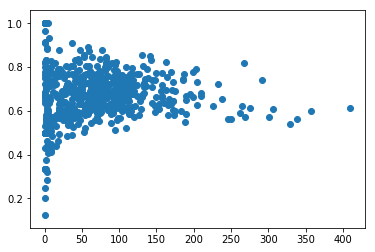

In [444]:
plt.pyplot.scatter(ppc_stats_a[:, 3], ppc_stats_a[:, 0])

### PPCs to put into paper
We look at tightly and loosely knit communities, for PPCs of varying sizes; see the following plots. 
At the end, we give a table of PPC stats, where the columns are as above. 
It can be seen that for the "tighter" communities (rows 1,3,5) the `upc` value is lower than for the looser communities (rows 2,4,6). But the `uppcc` values are comparable, and in fact higher for the tighter communities. 

In [404]:
ks = [296, 456, 429, 213, 395, 380]
[[round(x,2) for x in ppc_stats[k]] for k in ks]

[[0.64, 0.84, 0.34, 172.5],
 [0.79, 0.82, 0.64, 203.0],
 [0.62, 0.9, 0.22, 82.43],
 [0.73, 0.79, 0.32, 91.43],
 [0.62, 0.94, 0.2, 116.85],
 [0.75, 0.82, 0.44, 105.53]]

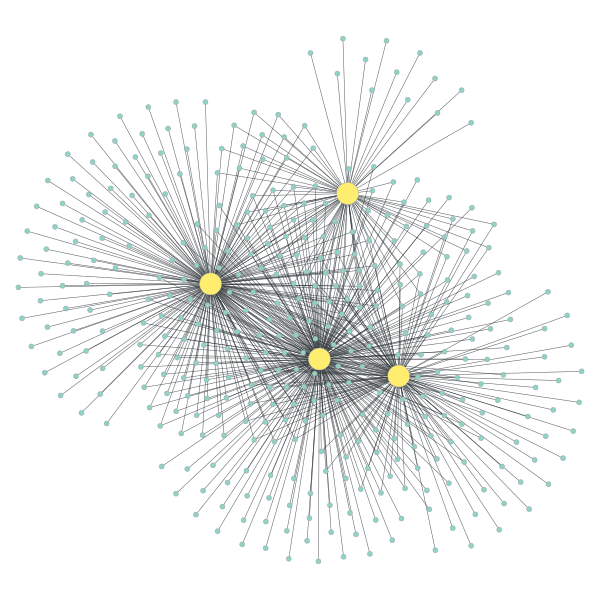

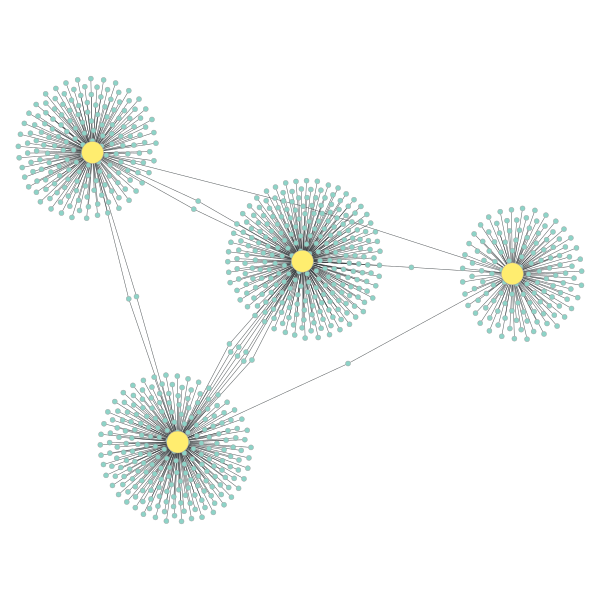

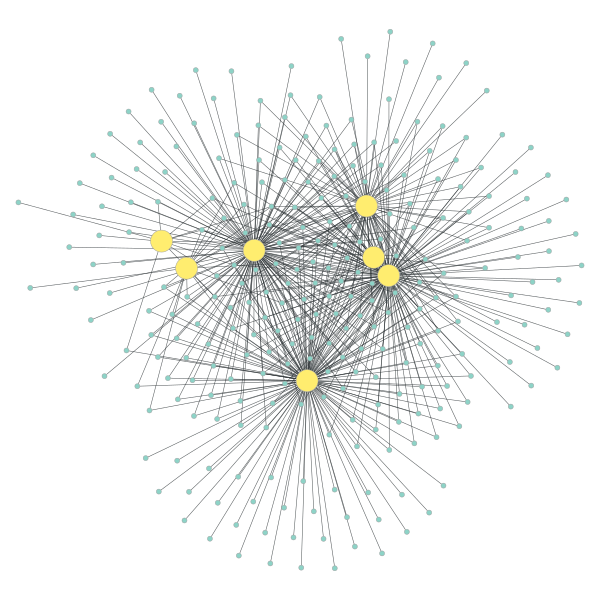

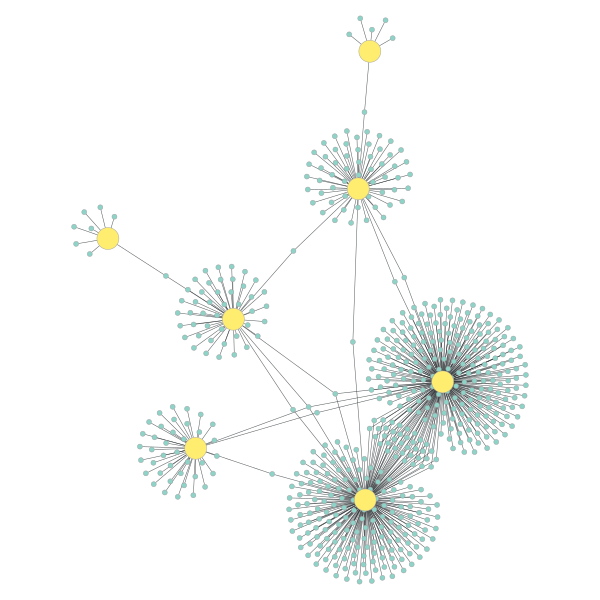

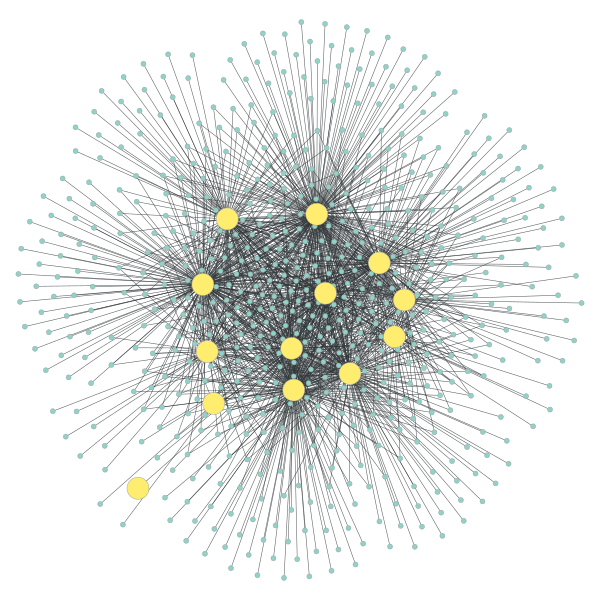

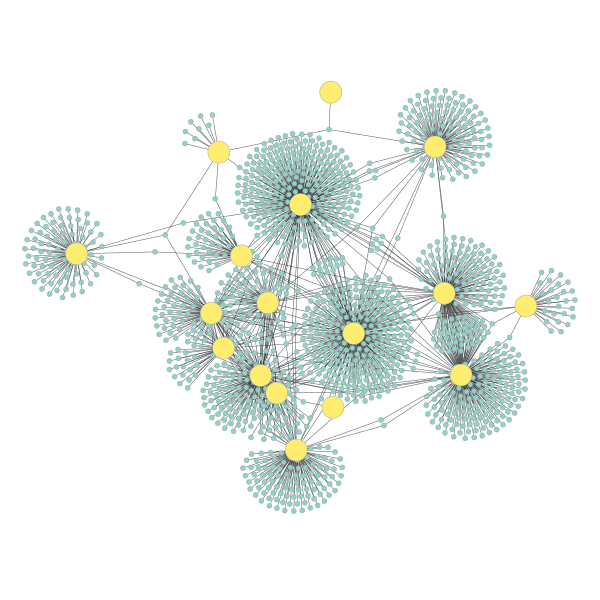

In [377]:
for k in ks:
    g = mbs.PPCgraph(states[2], k)
    mbs.plot_PPCgraph(g)